In [1]:
import distutils.spawn
from matplotlib import rc
from matplotlib import pyplot as plt
import os
import pandas as pd
import seaborn as sns
import torch

torch.manual_seed(0)

sns.set(font_scale=1.5)
if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

filedir = os.path.join('figures', '10d')
os.makedirs(filedir, exist_ok=True)

In [2]:
def sigma(x):
    """Activation function."""
    z = torch.zeros_like(x)
    return torch.minimum(torch.maximum((4*(x+0.5)**3), z), z+0.5) \
        + torch.minimum(torch.maximum((0.5 - 4*(0.5-x)**3), z), z+0.5)

In [3]:
class mynn(torch.nn.Module):
    def __init__(self, a, u, eta):
        super(mynn, self).__init__()
        self.a = torch.nn.Parameter(a)
        self.u = torch.nn.Parameter(u)
        self.eta = eta
        self.sigma = lambda x: sigma(x / self.eta)

    def forward(self, x):
        return torch.sum(self.a[..., None] * self.sigma(x - self.u[..., None]), dim = (0, 1))

In [4]:
def target(x):
    return torch.sum((x > 0.3).double(), axis = 0) + torch.sum((x > 0.5).double(), axis = 0) + torch.sum((x > 0.7).double(), axis = 0)

In [7]:
n_repeats = 20
n_batch = 10**4
n_neurons = 10
d = 10

metrics = {'loss': [], 'u': [], 'a': []}
for k in range(n_repeats):
    print('repeat: {}'.format(k))
    x = torch.rand(d, n_batch)
    u = torch.rand(n_neurons, d)
    a = 3 * torch.rand(n_neurons, d)
    model = mynn(a, u, 0.01)
    optimizer = torch.optim.SGD(model.parameters(), lr=1.0)
    
    n_epoch = 300
    for epoch in range(n_epoch):
        optimizer.zero_grad()
        y_pred = model(x)
        y_target = target(x)
        criterion = torch.norm(y_pred - y_target) / n_batch
        criterion.backward()
        optimizer.step()
    metrics['loss'].append(float(criterion))
    metrics['u'].append(model.u.detach().numpy())
    metrics['a'].append(model.a.detach().numpy())

repeat: 0
repeat: 1
repeat: 2
repeat: 3
repeat: 4
repeat: 5
repeat: 6
repeat: 7
repeat: 8
repeat: 9
repeat: 10
repeat: 11
repeat: 12
repeat: 13
repeat: 14
repeat: 15
repeat: 16
repeat: 17
repeat: 18
repeat: 19


In [6]:
metrics_fs = {'loss': [], 'u': [], 'a': []}
for k in range(n_repeats):
    print('repeat: {}'.format(k))
    x = torch.rand(d, n_batch)
    u = torch.rand(10, d)
    a = 3 * torch.rand(10, d)
    model = mynn(a, u, 0.01)
    optimizer_a = torch.optim.SGD([model.a], lr=1.0)
    optimizer_u = torch.optim.SGD([model.u], lr=0.01)
    
    n_epoch = 5 * 10**3
    for epoch in range(n_epoch):
        optimizer_a.zero_grad()
        optimizer_u.zero_grad()
        y_pred = model(x)
        y_target = target(x)
        criterion = torch.norm(y_pred - y_target) / n_batch
        if epoch % 1000 == 0:
            print(criterion)
        criterion.backward()
        optimizer_a.step()
        optimizer_u.step()
    metrics_fs['loss'].append(float(criterion))
    metrics_fs['u'].append(model.u.detach().numpy())
    metrics_fs['a'].append(model.a.detach().numpy())

repeat: 0
tensor(0.6935, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0139, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0079, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0058, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0041, dtype=torch.float64, grad_fn=<DivBackward0>)
repeat: 1
tensor(0.6716, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0167, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0109, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0082, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0064, dtype=torch.float64, grad_fn=<DivBackward0>)
repeat: 2
tensor(0.5771, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0161, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0106, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0081, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0069, dtype=torch.float64, grad_fn=<DivBackward0>)
repeat: 3
tensor(0.6844, dtype=torch.float64, grad_fn=<DivBackward0>)


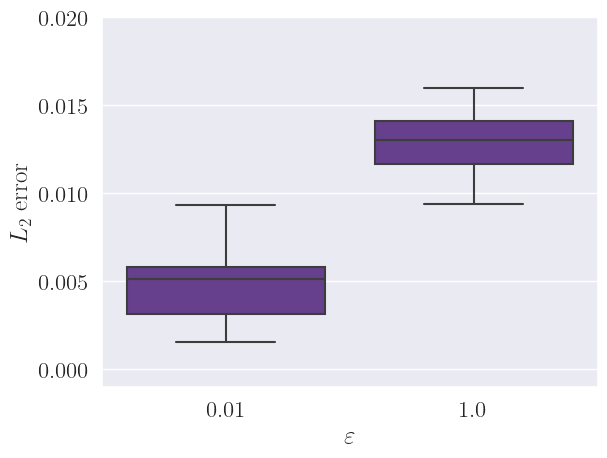

In [9]:
d = {r'$\varepsilon$': [1.0]*20 + [0.01]*20, r'$L_2$ error': metrics['loss'] + metrics_fs['loss']}
df = pd.DataFrame.from_dict(d)
sns.boxplot(data=df, x=r'$\varepsilon$', y=r'$L_2$ error', color='rebeccapurple')
plt.ylim([-0.001, 0.02])
plt.savefig(os.path.join(filedir, 'plot_error_10d.png'), dpi=150, bbox_inches='tight')
plt.show()